Phase 3 is Predictive Modeling
 
1.	Define Nifty_Dir_Open =1/0 based on direction (dependent variable) (already derived in phase 2)
2.	Create data partition into train and test data sets (80/20)
3.	Run Binary Logistic Regression with Nifty Direction as dependent variable and previous day global market returns (and VIX) as independent variables. You may add more features such as previous day High/Low ratio for Nifty 50 and/or DJI
4.	Check multicollinearity and resolve if present
5.	Check which variables are significant (revise the model if needed)
6.	Obtain ROC curve and AUC for train data
7.	Obtain threshold to balance sensitivity and specificity
  	Go to step 8 only if you are satisfied with model on train data 
8. Obtain ROC curve and AUC for test data (compare with step 6)
9. Use above threshold to obtain sensitivity and specificity for test data 
         (compare with step 7)
10.	Finalize the model

In [ ]:
import pandas as pd


df = pd.read_csv('markets_with_returns.csv')

# List of market return columns to be used in methods below
market_return_columns = [
    'DowJones_Return', 'Nasdaq_Return',
    'HangSeng_Return', 'Nikkei_Return', 'DAX_Return', 'VIX_Return' ]


In [23]:
# Define Nifty_Dir_Open =1/0 based on direction (dependent variable) (already derived in phase 2)
df['Nifty_Dir_Open'] = (df['Nifty_Return'] > 0).astype(int)
df.describe()

,Nifty_Open,Nifty_Close,DowJones_Open,DowJones_Close,Nasdaq_Open,Nasdaq_Close,HangSeng_Open,HangSeng_Close,Nikkei_Open,Nikkei_Close,...,DowJones_Return,Nasdaq_Return,HangSeng_Return,Nikkei_Return,DAX_Return,VIX_Return,Quarter,Month,Year,Nifty_Dir_Open
count,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,...,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000
mean,16730.809735,16720.344590,32958.507411,32962.678739,12798.080676,12800.410732,22865.188046,22858.875951,28728.350377,28726.524259,...,0.017619,0.034079,-0.016966,0.000484,0.024660,-0.827288,2.447480,6.328476,2021.681239,0.479053
std,4562.141460,4563.917864,5417.343038,5416.830025,3374.715490,3371.583671,4175.877411,4169.366472,5996.665587,5991.895916,...,0.930121,1.190489,1.124334,0.921634,0.926731,7.493957,1.126076,3.479439,1.835529,0.499713
min,7735.149902,7610.250000,19028.359375,18591.929688,6506.910156,6463.500000,14830.690430,14687.019531,16570.570312,16552.830078,...,-5.328405,-6.602975,-8.413594,-10.754634,-7.125518,-34.052571,1.000000,1.000000,2019.000000,0.000000
25%,11968.625000,11946.325195,28217.995117,28237.584961,10471.260254,10474.540039,19345.159180,19363.695312,23418.344727,23409.665039,...,-0.404531,-0.548907,-0.674519,-0.422044,-0.381603,-5.030503,1.000000,3.000000,2020.000000,0.000000
50%,17183.449219,17176.699219,33516.429688,33530.828125,12968.379883,12997.750000,23207.070312,23192.630859,27928.089844,27927.470703,...,0.044580,0.081241,-0.037169,-0.003170,0.081575,-1.911698,2.000000,6.000000,2022.000000,0.000000
75%,19632.125000,19656.700195,35646.585938,35724.955078,15024.660156,15049.970215,26491.054688,26464.600586,32656.615234,32691.089844,...,0.481138,0.675767,0.622819,0.465095,0.496467,1.809592,3.000000,9.000000,2023.000000,1.000000
max,26248.250000,26216.050781,45054.359375,45014.039062,20114.980469,20173.890625,31183.359375,31084.939453,42343.718750,42224.019531,...,8.613852,11.961279,6.721295,8.099586,5.534786,77.392430,4.000000,12.000000,2025.000000,1.000000


In [17]:
# Create data partition into train and test data sets (80/20)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)


In [22]:
# Clean the data first - remove any rows with missing values
clean_train_df = train_df[market_return_columns + ['Nifty_Dir_Open']]

X_clean = clean_train_df[market_return_columns]
y_clean = clean_train_df['Nifty_Dir_Open']

# Run logistic regression
import statsmodels.api as sm

X_train_clean = sm.add_constant(X_clean)

try:
    logit_model = sm.Logit(y_clean, X_train_clean)
    result = logit_model.fit(method='bfgs', maxiter=1000, disp=True)
    print(result.summary())

    # Check for convergence
    if result.mle_retvals['converged']:
        print("\n✓ Model converged successfully!")
    else:
        print("\n⚠ Model did not converge - trying different method...")
        result = logit_model.fit(method='newton', maxiter=1000)
        print(result.summary())

except Exception as e:
    print(f"Error: {e}")
    print("\nTrying sklearn's regularized logistic regression...")

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)

    lr_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
    lr_model.fit(X_scaled, y_clean)

    print("\nSklearn Results:")
    for feature, coef in zip(market_return_columns, lr_model.coef_[0]):
        print(f"{feature:20s}: {coef:8.4f}")
    print(f"{'Intercept':20s}: {lr_model.intercept_[0]:8.4f}")
    print(f"\nTraining accuracy: {lr_model.score(X_scaled, y_clean):.4f}")

Optimization terminated successfully.
         Current function value: 0.669157
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
                           Logit Regression Results                           
Dep. Variable:         Nifty_Dir_Open   No. Observations:                 1317
Model:                          Logit   Df Residuals:                     1310
Method:                           MLE   Df Model:                            6
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                 0.03393
Time:                        00:05:18   Log-Likelihood:                -881.28
converged:                       True   LL-Null:                       -912.24
Covariance Type:            nonrobust   LLR p-value:                 1.838e-11
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0646  

In [24]:
# Check multicollinearity and remove variables with high VIF if necessary

# Check VIF for multicollinearity
vif_data = pd.DataFrame()
vif_data["Feature"] = X_clean.columns
vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) for i in range(len(X_clean.columns))]
print("Variance Inflation Factors:")
print(vif_data)


for feature in vif_data[vif_data["VIF"] > 5]["Feature"]:
    print(f"Removing feature {feature} due to high VIF of {vif_data[vif_data['Feature'] == feature]['VIF'].values[0]}")
    X_clean = X_clean.drop(columns=[feature])


Variance Inflation Factors:
           Feature       VIF
0  DowJones_Return  2.844617
1    Nasdaq_Return  2.490088
2  HangSeng_Return  1.058940
3    Nikkei_Return  1.098003
4       DAX_Return  1.309126
5       VIX_Return  1.870976



Training AUC: 0.6271


(0.0, 1.05)

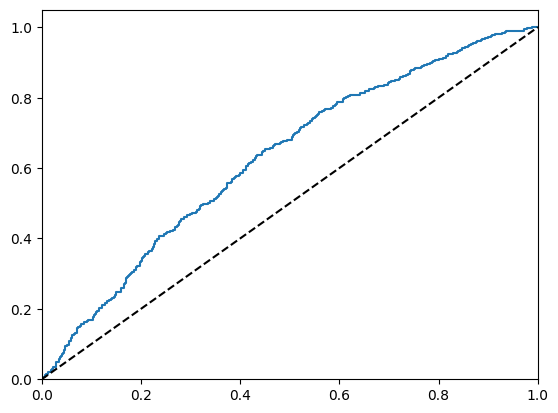

In [26]:
# Obtain ROC curve and AUC for train data
from sklearn.metrics import roc_curve, roc_auc_score
if 'logit_model' in locals():
    y_train_pred_prob = result.predict(X_train_clean)
else:
    X_train_scaled = scaler.transform(X_clean)
    y_train_pred_prob = lr_model.predict_proba(X_train_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_clean, y_train_pred_prob)
auc = roc_auc_score(y_clean, y_train_pred_prob)
print(f"\nTraining AUC: {auc:.4f}")
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


In [ ]:
# Obtain threshold to balance sensitivity and specificity

